# Assignment 3 (Exercise 1) Vision Transformers (10 pts)

In this exercise, we will explore a recent trend in computer vision: Transformers for image recognition. Since [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied Transformers to various image recognition benchmarks, numerous follow-up studies have suggested that CNNs may no longer be the go-to architecture for computer vision tasks.

In this exercise, we will implement a Vision Transformer and train it on the MNIST dataset. *We recommend completing this assignment using Google Colab with Chrome Browser*.

**Submit**
1. (<font color='red'>Doc A</font>) Figures and numerical results required in the following questions (include them in the pdf generated by latex file with Exercise 2)
2. (<font color='red'>Doc B</font>) The completed *.ipynb file with all the command outputs (can be created by saving the file after finishing the experiment and downloading it from Colab)
3. (<font color='red'>Doc C</font>) The PDF version of the saved *.ipynb file (can be created by printing it as a PDF file in Chrome)


## Setup


1. In Colab, open tab Runtime > Change runtime type, choose *python3* and *T4 GPU*.
2. Run the following command to set up the environment. (Takes ~ 1.5 min)



In [1]:
! pip install --quiet "ipython[notebook]==7.34.0, <8.17.0" "setuptools>=68.0.0, <68.3.0" "tensorboard" "lightning>=2.0.0" "urllib3" "torch==2.3.0" "numpy<2" "matplotlib" "pytorch-lightning>=1.4, <2.1.0" "seaborn" "torchvision" "torchmetrics>=0.7, <1.3" "matplotlib>=3.0.0, <3.9.0"

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/4UyBxlJChfc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Let's start with importing our standard set of libraries.

In [2]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import MNIST

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 5 epoch is sufficient to get full mark.
  print('GPU is not detected. Make sure you have chosen the right runtime type')

Seed set to 42


Everything looks good; continue


<Figure size 640x480 with 0 Axes>

## Dataloaders (0 pt)

We load the MNIST dataset below.
The constants in the `transforms.Normalize` correspond to the values
that scale and shift the data to a zero mean and standard deviation of
one.

Seed set to 42
Seed set to 42


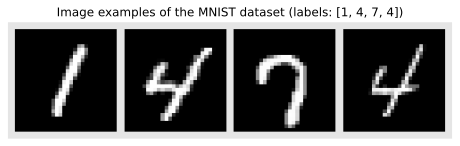

In [3]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.1307,], [0.3081,]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((28, 28), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.1307,], [0.3081,]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = MNIST(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [55000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=15)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=15)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=15)

# Visualize some examples
NUM_IMAGES = 4
MNIST_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
MNIST_labels = [val_set[idx][1] for idx in range(NUM_IMAGES)]

img_grid = torchvision.utils.make_grid(MNIST_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title(f"Image examples of the MNIST dataset (labels: {MNIST_labels})")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Transformers for image classification (2 pts)

Transformers were originally proposed to process sets due to their permutation-equivariant architecture, meaning they produce the same output if the input is permuted. To apply Transformers to sequences, we added positional encoding to the input feature vectors, allowing the model to learn how to use this information effectively. So, why not apply the same approach to images?
This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." Specifically, the Vision Transformer (ViT) is a model for image classification that views images as sequences of smaller patches.

As a preprocessing step, we split an MNIST image of \(28 x 28\) pixels into 49 \(4 x 4\) patches. Each of these patches is considered a "word" or "token" and is projected into a feature space. By adding positional encodings and a classification token, we can apply a Transformer to this sequence and start training it for our task.
A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/vit_architecture.png" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves.


### Split up images
An image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$.

These represent the input words to the Transformer.

<font color='red'>(Complete the following coding block, 1pt)</font>


In [4]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """

    # B: batch_size
    # C: Num of channels
    # H: number of pixels vertically (Height)
    # W: number of pixels horizontally (Width)

    B, C, H, W = x.shape

    # p_H: number of patches vertically
    p_H = H // patch_size
    # p_W: number of patches horizontally
    p_W = W // patch_size

    # Reshape x into [B, p_H*p_W, C, patch_size, patch_size]
    x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    x = x.permute(0, 2, 3, 1, 4, 5).contiguous().view(
        B, p_H * p_W, C, patch_size, patch_size)

    if flatten_channels:
        x = x.flatten(2)  # [B, p_H*p_W, C*patch_size^2]

    return x

Let's take a look at how that works for our MNIST examples above.
For our images of size $28\times 28$, we choose a patch size of 4.
Hence, we obtain sequences of 49 patches of size $4\times 4$.
We visualize them below:


<font color='red'>(Run the following command and report the outputted plots in Doc A, 1pt)</font>

You should get four plots similar to this:

<img src="https://github.com/watml/CS480_assignments_imgs/blob/3d4cbbfeea344cfc9f008cb1b7f53d3cea5f10e9/CS480/ass3/demo1.png?raw=true" alt="drawing" width="100"/>



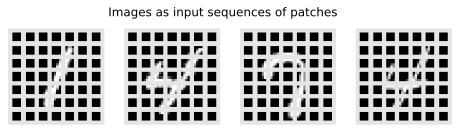

In [5]:
img_patches = img_to_patch(MNIST_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(1, MNIST_images.shape[0], figsize=(8, 2))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=7, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    plt.imsave(f"img/img_grid_{i}.png", img_grid.numpy())
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from these patch lists. Still, this is the input we provide to the Transformer for classifying the images. The model must learn how to combine the patches to recognize the objects. The inductive bias in CNNs, that an image is a grid of pixels, is lost in this input format.



## Building Models  (3 pts)
After examining the preprocessing steps, we can now start building the Transformer model. We will use the PyTorch module `nn.MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)) to implement the attention mechanism.



### Attention block



We will use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020. The idea is to apply Layer Normalization not between residual blocks, but instead as the first layer within the residual blocks. This reorganization supports better gradient flow and removes the necessity of a warm-up stage. Below is a visualization of the difference between the standard Post-LN and the Pre-LN versions.

<center width="100%"><img src="https://github.com/watml/CS480_assignments_imgs/blob/main/CS480/ass3/demo2.png?raw=true" width="400px"></center>





<font color='red'>(Follow the plot (b) above to complete the following coding block for the implementation of the Pre-LN Transformer layer, 3pt)</font>


In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Apply LayerNorm, Attention, and Residual Connection
        x_norm = self.norm(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_output

        # Apply LayerNorm, Feed-Forward Network, and Residual Connection
        x_norm = self.norm(x)
        x = x + self.ffn(x_norm)

        return x

## Vision Transformer (2 pts)

Now, we have all the modules to build the Vision Transformer.

In addition to the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. This is implemented by a simple linear layer that processes each \( M x M \) patch independently.
* A **classification token** that is added to the input sequence. The output feature vector of this classification token (CLS token) will be used to determine the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. These encodings are necessary to capture position-dependent information and convert the set of patches into a sequence. Since we typically work with a fixed resolution, we can learn the positional encodings instead of using predefined sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token and maps it to a classification prediction. This is usually implemented as a small feed-forward network or even a single linear layer.


<font color='red'>(Complete the following coding block, 2 pts)</font>

In [7]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors for the Transformer.
            hidden_dim: Dimensionality of the hidden layer in the Transformer's feed-forward networks.
            num_channels: Number of channels in the input (e.g., 1 for grayscale, 3 for RGB).
            num_heads: Number of heads in the Multi-Head Attention block.
            num_layers: Number of layers in the Transformer.
            num_classes: Number of classes for classification.
            patch_size: Size of each patch in pixels per dimension.
            num_patches: Maximum number of patches an image can contain.
            dropout: Dropout rate for the feed-forward network and the input encoding.
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(
            embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(
            torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # 1. concatenate cls_token to all pixels (1 pt)
        x = torch.cat((cls_tokens, x), dim=1)

        # 2. add pos_embedding (1 pt)
        x = x + self.pos_embedding[:, :T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

## Training Pipeline

Finally, we can put everything into a [PyTorch Lightning Module](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

PyTorch Lightning is a high-level framework built on top of PyTorch that is designed to streamline the process of building and training complex deep learning models. PyTorch Lightning automates common training tasks such as checkpointing, logging, and GPU/TPU training, reducing the need for repetitive code. Check this 15-minute [intro video](https://lightning.ai/docs/pytorch/stable/starter/introduction.html) for more information.




We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation.
Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore.
Instead, we use the same learning rate scheduler as the CNNs in the previous assignment.

In [8]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]  # For plotting the computation graph

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return [optimizer], []

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

## Experiments (3 pts)

Commonly, Vision Transformers are used for large-scale image classification tasks such as ImageNet to fully leverage their capabilities. However, for demonstration purposes, we are training a Vision Transformer from scratch on the MNIST dataset.


Let's start by creating a training function for our PyTorch Lightning module.

In [9]:
def train_model(**kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # Enable computation graph plotting in TensorBoard
    trainer.logger._default_hp_metric = None  # Disable default hyperparameter logging

    # Check for an existing pretrained model
    pretrained_path = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_path):
        print(f"Found pretrained model at {pretrained_path}, loading...")
        model = ViT.load_from_checkpoint(pretrained_path)
    else:
        L.seed_everything(42)  # Ensure reproducibility
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load the best checkpoint after training
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Evaluate the best model on validation and test sets
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    results = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, results

Start [tensorboard](https://www.tensorflow.org/tensorboard) to monitor the training process.

(**Note:** a webpage will show up once you run the following command. Press refresh button on the top right corner to refresh or click the gear button to enable automatic refresh)

(**Note:** All logs are cached unless you restart the runtime environment. If the webpage is stuck or missing some tabs, you can re-run the following command without losing any logged results.)

In [12]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%load_ext tensorboard
%tensorboard --logdir saved_models/VisionTransformers/ViT/lightning_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 212438), started 0:06:24 ago. (Use '!kill 212438' to kill it.)

Now, we can start training our model.

Feel free to explore the hyperparameters by adjusting the values below. Generally, the Vision Transformer has not shown to be overly sensitive to hyperparameter choices on the MNIST dataset.

In [11]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 64,
        "hidden_dim": 128,
        "num_heads": 4,
        "num_layers": 3,
        "patch_size": 4,
        "num_channels": 1,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.1,
    },
    lr=3e-4,
)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 106 K  | train | [128, 1, 28, 28] | [128, 10]
-----------------------------------------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.9289000034332275, 'val': 0.920199990272522}


<font color='red'> Report the test accuracy in Doc A. (1 pt)</font>

<font color='red'> Take a screenshot from tensorboard for train_acc vs epochs and include it in Doc A. (1 pt)</font>

<font color='red'> Take a screenshot from tensorboard for val_acc vs epochs and include it in Doc A. (1 pt)</font>

(**Note**: The last plots can be found in **SCALARS**. If necessary, rerun the tensorboard-related commands after the training is completed.)


## References

Dosovitskiy, Alexey, et al.
"An image is worth 16x16 words: Transformers for image recognition at scale."
International Conference on Representation Learning (2021).
[link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al.
"When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations."
arXiv preprint arXiv:2106.01548 (2021).
[link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al.
"MLP-mixer: An all-MLP Architecture for Vision."
arXiv preprint arXiv:2105.01601 (2021).
[link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al.
"On layer normalization in the transformer architecture."
International Conference on Machine Learning.
PMLR, 2020.
[link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)